<a href="https://colab.research.google.com/github/valgh/colab_notebooks/blob/main/transformer_encodings_cfg_asm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# now we can start working with our dataset.
# mounting drive...
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)

Mounted at /content/gdrive/


In [4]:
import json
randwalks_seq = json.load(open("/content/gdrive/My Drive/randwalk_text_embedded_10000.json", "r"))
num_samples = len(randwalks_seq)
print(num_samples)

10000


In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import time

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Running on TPU  ['10.58.225.154:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.58.225.154:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.58.225.154:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [6]:
# importing punkt from nltk 
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
# DATASET PREPROCESSING STEP

# something else we should do is filter out same randwalks. We just need to keep,
# for each function, the randwalks that are different one from another, and discard
# the 'duplicates'.

# There is also something else we should apply here: STEMMING om the functions names,
# and then filtering out all those tokens that just represent an identifier for 
# the software ("gsl", "gl", "gnu", see IN NOMINE FUNCTION paper chapter 4).

from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 

# Maximum number of samples to preprocess
MAX_SAMPLES = 10000

def create_token_selection(randwalks_seq):
  out = {}
  stemmer = PorterStemmer()
  for name in randwalks_seq:
    # same preprocessing sytep as reported below
    name = name.strip()
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    name = re.sub(r"([?.!,])", r" \1 ", name)
    name = re.sub(r'[" "]+', " ", name)
    # replacing everything with space except (a-z, A-Z, 0-9)
    name = re.sub(r"[^a-zA-Z0-9]+", " ", name)
    name = re.sub(r"([A-Z])", r" \1", name)
    tokens = word_tokenize(name)
    for token in tokens:
      stemmed_token = stemmer.stem(token)
      if stemmed_token in out:
        out[stemmed_token] += 1
      else:
        out[stemmed_token] = 1
  return out

def stem_and_filter_tokens(sentence, token_selection):
  stemmer = PorterStemmer()
  tokens = word_tokenize(sentence)
  threshold = 50
  out = ""
  for token in tokens:
    stemmed_token = stemmer.stem(token)
    if token_selection[stemmed_token] > threshold:
      out += " "+stemmed_token
  return out

def preprocess_seq(sentence, is_name, token_selection):
  sentence = sentence.strip()
  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  # replacing everything with space except (a-z, A-Z, 0-9)
  sentence = re.sub(r"[^a-zA-Z0-9]+", " ", sentence)
  if is_name == True:
    # place a space between lower and upper case letter -> "getCommand" ---> "get Command"
    sentence = re.sub(r"([A-Z])", r" \1", sentence)
    sentence = stem_and_filter_tokens(sentence, token_selection)
  sentence = sentence.strip()
  # adding a start and an end token to the sentence
  return sentence


def load_dataset(randwalks_seq, MAX_SAMPLES, token_selection):
  # dictionary of name to string sequences
  check = {}
  names = []
  sequences = []
  counter = 0
  for name in randwalks_seq:
    counter+=1
    print(counter)
    if counter == MAX_SAMPLES:
      break
    preprocessed_name = preprocess_seq(name, True, token_selection)
    check[preprocessed_name] = {}
    for seq in randwalks_seq[name]:
      for l in randwalks_seq[name][seq]:
        seq_as_str = ""
        for el in l:
          preprocessed_seq = preprocess_seq(el, False, token_selection)
          seq_as_str += " "+preprocessed_seq
        if seq_as_str not in check[preprocessed_name]:
          check[preprocessed_name][seq_as_str] = 0
          names.append(preprocessed_name)
          sequences.append(seq_as_str)
  return names, sequences

token_selection = create_token_selection(randwalks_seq)
print(len(token_selection))
names, sequences = load_dataset(randwalks_seq, MAX_SAMPLES, token_selection)

print(len(sequences))

print('Sample function name: {}'.format(names[120]))
print('Sample sequence: {}'.format(sequences[120]))

#  now splitting dataset into train and test sets

# now we split our dataset into train, development and test
from sklearn.model_selection import train_test_split
rest_seq, test_seq, rest_names, test_names = train_test_split(sequences, names, test_size=0.05, random_state=1)
train_seq, dev_seq, train_names, dev_names = train_test_split(rest_seq, rest_names, test_size=0.05, random_state=1)

print("Train size:", len(train_seq))
print("Dev size:", len(dev_seq)) #not actually used here
print("Test size:", len(test_seq))

sequences = train_seq + dev_seq
names = train_names + dev_names

print(len(sequences))
print(len(names))
print(len(test_seq))
print(len(test_names))

Output streaming troncato alle ultime 5000 righe.
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201


In [8]:
# now we build a tfds tokenizer for both names and sequences
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    names + sequences, target_vocab_size=2**13)

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

print('Tokenized sample name: {}'.format(tokenizer.encode(names[120])))
print('Tokenized sample sequence: {}'.format(tokenizer.encode(sequences[120])))

Tokenized sample name: [2037]
Tokenized sample sequence: [7877, 34, 317, 421, 2453, 47, 629]


In [9]:
# Maximum sequence length 
MAX_LENGTH = 100

# Tokenize, filter and pad sentences
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # tokenize sentence
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
    # check tokenized sentence max length
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # pad tokenized sentences
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs


names, sequences = tokenize_and_filter(names, sequences)

print('Vocab size: {}'.format(VOCAB_SIZE))
print('Number of samples: {}'.format(len(sequences)))

Vocab size: 8103
Number of samples: 28688


In [10]:
# 64*570 = 36000 ca.
BATCH_SIZE = 64
BUFFER_SIZE = 570

# decoder inputs use the previous target as input
# remove START_TOKEN from targets

#dataset = tf.data.Dataset.from_tensor_slices((
#    {
#        'inputs': sequences,
#        'dec_inputs': names[:, :-1]
#    },
#    {
#        'outputs': names[:, 1:]
#    },
#))

dataset = tf.data.Dataset.from_tensor_slices((sequences, names))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [11]:
print(dataset)

<PrefetchDataset shapes: ((None, 100), (None, 100)), types: (tf.int32, tf.int32)>


In [ ]:
# please note that the following implementation of functions and classes for the Transformer
# comes (almost entirely, except for the encodings retrieval) from the following
# tutorial: https://www.tensorflow.org/tutorials/text/transformer - the 
# architecture is not the focus at this point so I figured it would be better
# to directly implement this to save some time and try different things and setups

(1, 50, 512)


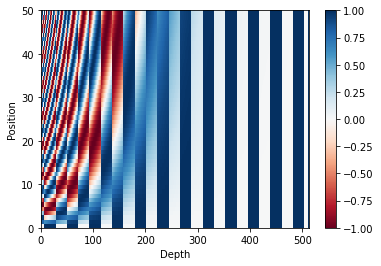

In [12]:
# POSITIONAL ENCODING FUNCTIONS DEFINITION

def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()


In [14]:
# PADDING/LOOKAHEAD MASKING FUNCTIONS DEFINITIONS

def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [15]:
# SCALED DOT PRODUCT ATTENTION DEFINITION

def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)



# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)



# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

# Pass all queries together
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)



Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)
Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)
Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)
Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


In [16]:
# MULTI HEADED ATTENTION CLASS
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [17]:
# Point-wise FFN (last layer of each Enc/Dec layer)

def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [18]:
# ENCODER LAYER

class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

# DECODER LAYER

class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)



sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)



TensorShape([64, 50, 512])

In [19]:
# GENERAL ENCODER/DECODER FOR TRANSFORMER

class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)



sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(64, 62, 512)


(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

In [20]:
# finally, TRANSFORMER CLASS

class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    # if we wish to retrieve the outputs,this is what we shuld look at!
    # we can save it as [target (tar), enc_output]!
    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    # we try to save the encodings here
    # maybe something to adjust here: retrieve only the LAST
    # in the range of the tokens/enc_outputs
    # this is the input though, we may have to ignore the tar_input
    # and only save the encodings, then pass ghem to the training step
    # and link each encoding to its corresponding tar_real value

    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return enc_output, final_output, attention_weights



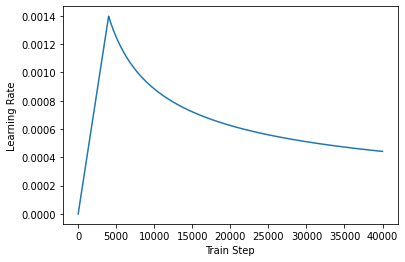

In [22]:
# SETTING HYPERPARAMETERS STEP

num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = VOCAB_SIZE
target_vocab_size = VOCAB_SIZE
dropout_rate = 0.1

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# LOSS AND METRICS STEP

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')



In [23]:
# DEFINE AND CREATE TRANSFORMER MODEL

transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

# CREATE MASKS FOR INPUTS

def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask


In [24]:
# DEFINING TRAINING STEP

EPOCHS = 10

# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
]

# HERE IS THE TRAINING STEP

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    enc_output, predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

  return enc_output

In [25]:
# TRAINING

encodings = {}

for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> asm, tar -> func_names
  for (batch, (inp, tar)) in enumerate(dataset):
    enc_out = train_step(inp, tar)
    # iterate over them, at the last epoch
    if epoch == EPOCHS-1:
      for n in range(len(tar)):
        func = tar[n].ref()
        enc = enc_out[n]
        if func not in encodings:
          encodings[func] = [enc]
        else:
          encodings[func].append(enc)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 9.0225 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.8466 Accuracy 0.0037
Epoch 1 Batch 100 Loss 8.5989 Accuracy 0.0069
Epoch 1 Batch 150 Loss 8.3796 Accuracy 0.0079
Epoch 1 Batch 200 Loss 8.1363 Accuracy 0.0085
Epoch 1 Batch 250 Loss 7.8564 Accuracy 0.0088
Epoch 1 Batch 300 Loss 7.5425 Accuracy 0.0090
Epoch 1 Batch 350 Loss 7.2150 Accuracy 0.0092
Epoch 1 Batch 400 Loss 6.9041 Accuracy 0.0093
Epoch 1 Loss 6.6364 Accuracy 0.0094
Time taken for 1 epoch: 592.9921338558197 secs

Epoch 2 Batch 0 Loss 4.2311 Accuracy 0.0101
Epoch 2 Batch 50 Loss 4.1833 Accuracy 0.0101
Epoch 2 Batch 100 Loss 4.0916 Accuracy 0.0101
Epoch 2 Batch 150 Loss 3.9886 Accuracy 0.0103
Epoch 2 Batch 200 Loss 3.8935 Accuracy 0.0104
Epoch 2 Batch 250 Loss 3.8121 Accuracy 0.0107
Epoch 2 Batch 300 Loss 3.7330 Accuracy 0.0110
Epoch 2 Batch 350 Loss 3.6589 Accuracy 0.0112
Epoch 2 Batch 400 Loss 3.5942 Accuracy 0.0114
Epoch 2 Loss 3.5356 Accuracy 0.0116
Time taken for 1 epoch: 579.6810486316681 secs

Epoch 3 Ba

In [27]:
# now getting the encodings
# we should have a dictionary of tokens -> list of their encodings

print(len(encodings))

#output: 28688, it's what we were hoping for
# we should have encodings for all the inputs here
# by de-tokenizing each element in the numpy array of 'tokens', 
# we should be able to retrieve the name of each function and its corresponding 
# econdings.


28688


In [28]:
# we exploit tokenizer.decode at next step
st = tokenizer.decode([20, 405, 675, 100])
print(st)

for tokens in encodings:
  l = tokens.deref().numpy()
  tl = l.tolist()
  tl_filtered = [i for i in tl if i != 0 and i < 8100] # removing padding tokens/end tokens
  print(tl_filtered)
  to_tup = tokenizer.decode(tl_filtered)
  print(to_tup)
  break

JMP t 0x2cpn 
[382]
read


In [29]:
# there might be something to adjust here

final_encodings = {}

for tokens in encodings:
  try:
    l = tokens.deref().numpy()
    tl = l.tolist()
    tl_filtered = [i for i in tl if i != 0 and i < 8100] # removing padding tokens/end tokens
    to_tup = tokenizer.decode(tl_filtered)
    for encoding in encodings[tokens]:
      if to_tup in final_encodings:
        final_encodings[to_tup].append(encoding.numpy())
      else:
        final_encodings[to_tup] = [encoding.numpy()]
  except:
    continue

print(len(final_encodings))
#print(final_encodings)

3417


In [31]:
# let's see what we have here
i=0
for tokens in final_encodings:
  print("Name: {}, Number of encodings: {}, sample_encoding: {}, shape of encodings: {}".format(tokens, len(final_encodings[tokens]), final_encodings[tokens][0], final_encodings[tokens][0].shape))
  i+=1
  if i > 10:
    break

Name: read, Number of encodings: 190, sample_encoding: [[-0.1227369  -0.03327103  0.02181468 ...  0.04837946 -0.65903664
  -0.00180625]
 [ 0.00363646  0.02754765  0.13562755 ...  0.14458467 -0.9743209
  -0.05186015]
 [-0.10757186 -0.01837586  0.03236189 ...  0.05559143 -0.06685971
  -0.08973664]
 ...
 [-0.13224244 -0.02054394  0.01954119 ...  0.08991502 -0.8623174
  -0.07471956]
 [-0.06591201  0.13205495  0.19868211 ...  0.2877744  -1.2877147
  -0.01385295]
 [-0.145563    0.00258766  0.05087273 ...  0.1080384  -0.76200557
  -0.00084361]], shape of encodings: (100, 128)
Name: pars config, Number of encodings: 22, sample_encoding: [[-0.01760408  0.001376    0.05511191 ... -0.43632796 -0.46178713
  -0.02689487]
 [ 0.03794449  0.01742444  0.0730675  ... -0.5672082  -0.5024412
   0.01619543]
 [-0.06039846  0.0084617   0.08171493 ... -0.5129679  -0.56985974
  -0.04857072]
 ...
 [-0.02678427 -0.09262286  0.05376421 ... -0.23849764 -0.387832
  -0.02638234]
 [ 0.04067817 -0.08805018  0.08574477

In [34]:
import numpy as np
np.savez(open("/content/gdrive/My Drive/transformer_enc_out", "wb"), final_encodings)

In [39]:
# EVALUATION STEPS

def evaluate(inp_sentence):
  inp_sentence = preprocess_seq(inp_sentence, False, token_selection)

  #inp_sentence = tf.expand_dims(
      #START_TOKEN + tokenizer.encode(inp_sentence) + END_TOKEN, axis=0)

  #encoder_input = tf.expand_dims(inp_sentence, 0)

  start_token = [tokenizer.vocab_size]
  end_token = [tokenizer.vocab_size + 1]
  
  # adding the start and end token
  inp_sentence = start_token + tokenizer.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # first word to transformer should be start token

  decoder_input = [tokenizer.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    enc_out, predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == tokenizer.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

def predict(sentence):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = tokenizer.decode([i for i in result 
                                            if i < tokenizer.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted name: {}'.format(predicted_sentence))

In [40]:
# test on : LEA RDI 0x11d920 CALL FUN MOV EDI 0x50 MOV RAX qword ptr 0x0011d920 ADD RSP 0x8 LEA RDX 0x11ccc0 CALL FUN RET XOR ECX ECX MOV RSI RAX LEA RSI AgsTimestamp
# which really is : ag get type
# output: ag messag deliveri get messag -> "ag get" gets predicted, with more epochs (20) the output is better ("ag get type")
print(transformer)
predict("LEA RDI 0x11d920 CALL FUN MOV EDI 0x50 MOV RAX qword ptr 0x0011d920 ADD RSP 0x8 LEA RDX 0x11ccc0 CALL FUN RET XOR ECX ECX MOV RSI RAX LEA RSI AgsTimestamp")

Input: LEA RDI 0x11d920 CALL FUN MOV EDI 0x50 MOV RAX qword ptr 0x0011d920 ADD RSP 0x8 LEA RDX 0x11ccc0 CALL FUN RET XOR ECX ECX MOV RSI RAX LEA RSI AgsTimestamp
Predicted name: ag messag deliveri get messag


In [ ]:
# now predicting for the test_samples
def evaluate_test(test_seq, test_names):
  for idx in range(len(test_seq)):
    print('Original Name: {}'.format(test_names[idx]))
    predict(test_seq[idx])

evaluate_test(test_seq, test_names)